In [1]:
!uv pip install seaborn
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

# Set the option to display all columns
pd.set_option('display.max_columns', None)

Audited 1 package in 23ms


# Load and process (full matrix) data

In [4]:
# Read the training and validation CSV files
train_df = pd.read_csv("examples/data/train_hc_dataset_20240915_044230.csv")
val_df = pd.read_csv("examples/data/val_hc_dataset_20240915_044230.csv")

In [56]:

display(train_df["verdict"].value_counts())

def extract_values(list_of_dicts):
    all_values = []
    for attr_dict in list_of_dicts:
        values = []
        for k, v in attr_dict.items():
            if k != "index":
                values.append(v)
        all_values.append(values)

    # This is an list of lists. Columns are the attributions for every input token. Rows are the attributions for every output token.
    # For example, to get the attribution of all output tokens to the first input token only, take the first row.
    # To get the attributions of the first output token to all input tokens, take the first column.
    # To get the average attribution per input token, take the mean of every row.
    return all_values



def pad_attrib(attrib, max_input_len, max_output_len):
    np_attrib = np.array(attrib)
    if np_attrib.shape[0] >= max_input_len:
        np_attrib = np_attrib[:max_input_len]
    if np_attrib.shape[1] >= max_output_len:
        np_attrib = np_attrib[:, :max_output_len]
    
    np_attrib = np.pad(np_attrib, ((0, max_input_len - np_attrib.shape[0]), (0, max_output_len - np_attrib.shape[1])), mode='constant')
    return np_attrib


# Preprocessing function
def preprocess_data(df, max_input_len=None, max_output_len=None):
    attributions_full = df["attributions_full"].apply(ast.literal_eval)

    df["prob_diff_sequence"] = attributions_full.apply(lambda x: extract_values(x[1]["data"]))
    df["cosine_sequence"] = attributions_full.apply(lambda x: extract_values(x[0]["data"]))

    # Encode 'verdict' into numerical labels
    le = LabelEncoder()
    df["verdict_label"] = le.fit_transform(df["verdict"])

    if max_input_len is not None:
        sample_input_len = max_input_len
        sample_output_len = max_output_len
    else:
        max_prob_diff_input_len = df["prob_diff_sequence"].apply(len).max()
        max_prob_diff_output_len = df["prob_diff_sequence"].apply(lambda x: len(x[0])).max()
        max_cosine_input_len = df["cosine_sequence"].apply(len).max()
        max_cosine_output_len = df["cosine_sequence"].apply(lambda x: len(x[0])).max()

        sample_input_len = max(max_prob_diff_input_len, max_cosine_input_len)
        sample_output_len = max(max_prob_diff_output_len, max_cosine_output_len)

    prob_diff_sequence_padded = np.array(
        df["prob_diff_sequence"].apply(lambda x: pad_attrib(x, sample_input_len, sample_output_len))
    )
    cosine_sequence_padded = np.array(
        df["cosine_sequence"].apply(lambda x: pad_attrib(x, sample_input_len, sample_output_len))
    )

    df['prob_diff_sequence_padded'] = prob_diff_sequence_padded.tolist()

    df['cosine_sequence_padded'] = cosine_sequence_padded.tolist()

    # Compute statistical features
    df["prob_diff_mean"] = df["prob_diff_sequence"].apply(np.mean)
    df["prob_diff_std"] = df["prob_diff_sequence"].apply(np.std)
    df["prob_diff_max"] = df["prob_diff_sequence"].apply(np.max)
    df["prob_diff_min"] = df["prob_diff_sequence"].apply(np.min)
    df["prob_diff_median"] = df["prob_diff_sequence"].apply(np.median)
    df["prob_diff_q25"] = df["prob_diff_sequence"].apply(lambda x: np.percentile(x, 25))
    df["prob_diff_q75"] = df["prob_diff_sequence"].apply(lambda x: np.percentile(x, 75))

    df["cosine_mean"] = df["cosine_sequence"].apply(np.mean)
    df["cosine_std"] = df["cosine_sequence"].apply(np.std)
    df["cosine_max"] = df["cosine_sequence"].apply(np.max)
    df["cosine_min"] = df["cosine_sequence"].apply(np.min)
    df["cosine_median"] = df["cosine_sequence"].apply(np.median)
    df["cosine_q25"] = df["cosine_sequence"].apply(lambda x: np.percentile(x, 25))
    df["cosine_q75"] = df["cosine_sequence"].apply(lambda x: np.percentile(x, 75))

    return df, sample_input_len, sample_output_len


# Preprocess training and validation data
train_df, sample_input_len, sample_output_len = preprocess_data(train_df)
val_df, sample_input_len, sample_output_len = preprocess_data(val_df, sample_input_len, sample_output_len)

# Define feature columns
prob_diff_features = [
    "prob_diff_mean",
    "prob_diff_std",
    "prob_diff_max",
    "prob_diff_min",
    "prob_diff_median",
    "prob_diff_q25",
    "prob_diff_q75",
]

cosine_features = [
    "cosine_mean",
    "cosine_std",
    "cosine_max",
    "cosine_min",
    "cosine_median",
    "cosine_q25",
    "cosine_q75",
]

prob_diff_sequence_cols = "prob_diff_sequence_padded"
cosine_sequence_cols = "cosine_sequence_padded"

verdict
Hallucination    50
Correct          50
Name: count, dtype: int64

# Prepare datasets and dataloaders

In [66]:
class HallucinationDataset(Dataset):
    def __init__(self, df, X_columns, y_column):
        self.sequences = df[X_columns].values
        self.labels = df[y_column].values

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = np.array([np.array(seq, dtype=np.float32) for seq in self.sequences[idx]])
        sequence = torch.tensor(sequence).reshape(-1)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence, label

    def sample(self, n):
        idx = np.random.choice(len(self), n, replace=False)
        return self.__getitem__(idx)


batch_size = 128

train_dataset = HallucinationDataset(train_df, prob_diff_sequence_cols, "verdict_label")
val_dataset = HallucinationDataset(val_df, prob_diff_sequence_cols, "verdict_label")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


stats_train_dataset = HallucinationDataset(train_df, prob_diff_features, "verdict_label")
stats_val_dataset = HallucinationDataset(val_df, prob_diff_features, "verdict_label")

stats_train_loader = DataLoader(stats_train_dataset, batch_size=batch_size, shuffle=True)
stats_val_loader = DataLoader(stats_val_dataset, batch_size=batch_size, shuffle=False)

# Training and evaluation functions

In [67]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, log_freq=20, device='cpu'):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        if (epoch + 1) % log_freq == 0:
            print(
                f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {100 * correct/total}%"
            )


# Function to evaluate model and compute multiple evaluation metrics
def evaluate_model(model, data_loader, device="cpu"):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Compute additional metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(
        all_labels, all_preds, average="weighted"
    )  # Use 'macro', 'micro', or 'weighted' depending on the task
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    # Return all metrics
    metrics = {
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

    return metrics


# Function to plot confusion matrix
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Correct Answer", "Hallucination"],
        yticklabels=["Correct Answer", "Hallucination"],
    )
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title(title)
    plt.show()


def show_eval(name, model, data_loader, device="cpu"):
    metrics = evaluate_model(model, data_loader, device)
    plot_confusion_matrix(metrics["confusion_matrix"], name)
    del metrics["confusion_matrix"]
    print(name, ": ", metrics)

# Model definitions

In [68]:
class LinearClassifier(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(LinearClassifier, self).__init__()
        self.weights = nn.Linear(input_shape, output_shape)

    def forward(self, x):
        out = self.weights(x.reshape(x.size(0), -1))
        return out


class SimpleNN(nn.Module):
    def __init__(self, input_shape, output_shape, breadth, depth, interpolate=True):
        super(SimpleNN, self).__init__()

        self.layers = []

        self.layers.append(nn.Linear(input_shape, breadth))
        self.layers.append(nn.ReLU())

        if interpolate:
            change_rate = int((breadth - output_shape) / max(1, depth))
            layer_sizes = [breadth - change_rate * i for i in range(depth)]

            for l in layer_sizes[:-1]:
                self.layers.append(nn.Linear(l, l - change_rate))
                self.layers.append(nn.ReLU())

            self.layers.append(nn.Linear(layer_sizes[-1], output_shape))

        else:
            for _ in range(depth - 1):
                self.layers.append(nn.Linear(breadth, breadth))
                self.layers.append(nn.ReLU())
            self.layers.append(nn.Linear(breadth, output_shape))

        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x.reshape(x.size(0), -1))


class SimpleConvNet(nn.Module):
    def __init__(self, input_shape, output_shape, breadth, depth):
        super(SimpleConvNet, self).__init__()

        layers = []
        in_channels = input_shape[1]
        ks = 3
        num_filters = breadth // (ks) ** 2

        # Add convolutional layers that maintain the input dimension
        for _ in range(depth):
            layers.append(nn.Conv1d(in_channels, num_filters, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_channels = num_filters

        self.conv_layers = nn.Sequential(*layers)

        # Calculate the size of the flattened output
        conv_output_shape = input_shape[1] * input_shape[2] * num_filters

        # Fully connected layer for classification
        self.fc = nn.Linear(conv_output_shape, output_shape)

    def forward(self, x):
        x = x.reshape(x.size(0), -1).unsqueeze(1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        return x


class SimpleRNN(nn.Module):
    def __init__(self, input_shape, output_shape, breadth, depth):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_shape,
            hidden_size=breadth,
            num_layers=depth,
            batch_first=True,
            bidirectional=True,
        )
        self.fc = nn.Linear(breadth, output_shape)

    def forward(self, x):
        x = x.reshape(x.size(0), -1).unsqueeze(1)
        _, h_n = self.rnn(x)
        out = self.fc(h_n[-1])
        return out

# Train models on stats


Training LinearClassifier...
Epoch 5/20, Train Loss: 0.7027291059494019, Val Loss: 0.6920105218887329, Val Accuracy: 55.0%
Epoch 10/20, Train Loss: 0.6965320110321045, Val Loss: 0.6951664686203003, Val Accuracy: 49.0%
Epoch 15/20, Train Loss: 0.6934443712234497, Val Loss: 0.6983058452606201, Val Accuracy: 43.0%
Epoch 20/20, Train Loss: 0.691104531288147, Val Loss: 0.6991978287696838, Val Accuracy: 44.0%


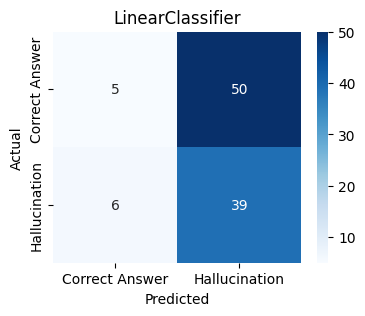

LinearClassifier :  {'accuracy': 0.44, 'precision': 0.44719101123595506, 'recall': 0.44, 'f1_score': 0.34527363184079607}


In [69]:
X_sample, y_sample = stats_train_dataset.sample(1)
input_shape = X_sample.shape[-1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps") if torch.backends.mps.is_available() else device

criterion = nn.CrossEntropyLoss()

stats_models = {"LinearClassifier": LinearClassifier(input_shape=input_shape, output_shape=2)}

optimizer = optim.Adam

for name, model in stats_models.items():
    print(f"\nTraining {name}...")
    model.to(device)
    train_model(
        model,
        stats_train_loader,
        stats_val_loader,
        criterion,
        optimizer(model.parameters(), lr=0.01),
        epochs=20,
        log_freq=5,
        device=device,
    )

    show_eval(name, model, stats_val_loader, device=device)


Training LinearClassifier...
Epoch 5/20, Train Loss: 0.562161386013031, Val Loss: 0.6789413690567017, Val Accuracy: 56.0%
Epoch 10/20, Train Loss: 0.49597182869911194, Val Loss: 0.6877809166908264, Val Accuracy: 58.0%
Epoch 15/20, Train Loss: 0.4524487555027008, Val Loss: 0.7354720234870911, Val Accuracy: 64.0%
Epoch 20/20, Train Loss: 0.4261116087436676, Val Loss: 0.7677170038223267, Val Accuracy: 66.0%


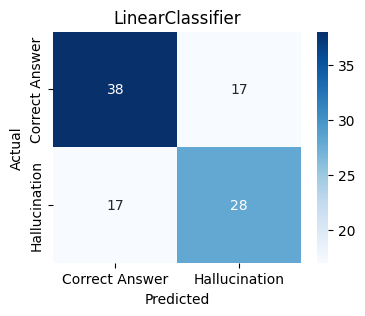

LinearClassifier :  {'accuracy': 0.66, 'precision': 0.66, 'recall': 0.66, 'f1_score': 0.66}

Training SimpleNN...
Epoch 5/20, Train Loss: 0.6394771337509155, Val Loss: 0.6898753643035889, Val Accuracy: 57.0%
Epoch 10/20, Train Loss: 0.5331687331199646, Val Loss: 0.7191730737686157, Val Accuracy: 60.0%
Epoch 15/20, Train Loss: 0.3961426615715027, Val Loss: 0.8029845952987671, Val Accuracy: 67.0%
Epoch 20/20, Train Loss: 0.30659058690071106, Val Loss: 1.0743820667266846, Val Accuracy: 64.0%


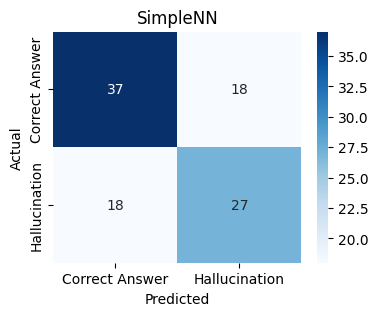

SimpleNN :  {'accuracy': 0.64, 'precision': 0.64, 'recall': 0.64, 'f1_score': 0.64}

Training SimpleConvNet...
Epoch 5/20, Train Loss: 8.262423515319824, Val Loss: 5.365535736083984, Val Accuracy: 55.0%
Epoch 10/20, Train Loss: 0.6340810656547546, Val Loss: 0.7375643849372864, Val Accuracy: 59.0%
Epoch 15/20, Train Loss: 0.5707691311836243, Val Loss: 0.6896629929542542, Val Accuracy: 59.0%
Epoch 20/20, Train Loss: 0.5265286564826965, Val Loss: 0.6864075660705566, Val Accuracy: 64.0%


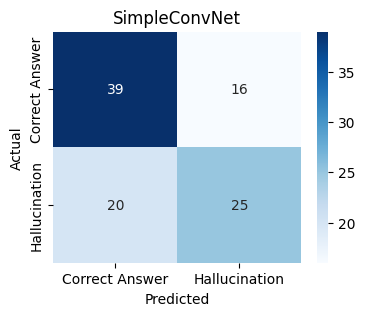

SimpleConvNet :  {'accuracy': 0.64, 'precision': 0.6379495659363373, 'recall': 0.64, 'f1_score': 0.6379436964504285}

Training SimpleRNN...
Epoch 5/20, Train Loss: 0.5240610241889954, Val Loss: 0.7219173908233643, Val Accuracy: 57.0%
Epoch 10/20, Train Loss: 0.36796265840530396, Val Loss: 0.9768307209014893, Val Accuracy: 71.0%
Epoch 15/20, Train Loss: 0.27228787541389465, Val Loss: 1.3430389165878296, Val Accuracy: 60.0%
Epoch 20/20, Train Loss: 0.20003627240657806, Val Loss: 1.7653824090957642, Val Accuracy: 62.0%


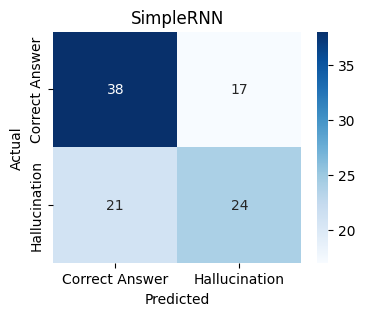

SimpleRNN :  {'accuracy': 0.62, 'precision': 0.6176519222819347, 'recall': 0.62, 'f1_score': 0.617829457364341}


In [70]:
X_sample, y_sample = train_dataset.sample(1)
input_shape = X_sample.reshape(1, -1).shape[-1]
criterion = nn.CrossEntropyLoss()

breadth, depth = 32, 2

models = {
    "LinearClassifier": LinearClassifier(input_shape=input_shape, output_shape=2),
    "SimpleNN": SimpleNN(input_shape=input_shape, output_shape=2, breadth=breadth, depth=depth),
    "SimpleConvNet": SimpleConvNet(
        input_shape=X_sample.reshape(1, -1).unsqueeze(1).shape, output_shape=2, breadth=breadth, depth=depth
    ),
    "SimpleRNN": SimpleRNN(input_shape=input_shape, output_shape=2, breadth=breadth, depth=depth),
}

optimizer = optim.Adam

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.to(device)
    train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer(model.parameters(), lr=0.01),
        epochs=20,
        log_freq=5,
        device=device
    )
    show_eval(name, model, val_loader, device=device)